In [2]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import seaborn as sns




In [3]:
hdf = pd.read_csv('kc_house_data.csv')
hdf = pd.DataFrame(hdf)

# hdf.info()



FileNotFoundError: [Errno 2] No such file or directory: 'kc_house_data.csv'

In [ ]:
# remove variables we do not plan to use
hdf = hdf.drop(columns=['id','date','zipcode'])

# separate continous and categorical variables
continuous_hdf = hdf[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15']]
categorical_hdf = hdf.drop(columns=['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15'])

# restitch dataset but now with all continuous variables together
hdf = pd.concat([continuous_hdf, categorical_hdf], axis=1)

# hdf.to_csv('kc_house_reorganised.csv')




In [ ]:
# make variables view, grade, condition binarised
hdf['view_b'] = hdf['view'] > 2
hdf['view_b'] = hdf['view_b'].astype(int)
hdf['condition_b'] = hdf['condition'] > 3
hdf['condition_b'] = hdf['condition_b'].astype(int)
hdf['grade_b'] = hdf['grade'] > 7
hdf['grade_b'] = hdf['grade_b'].astype(int)

# function to combine year built and year renovated into one binarised variable to see if house has been updated or created after 2000
def label_new(row):
    if row['yr_renovated'] > 2000 :
        return '1'
    elif row['yr_built'] > 2000 :
        return '1'
    else:
        return '0'

# def label_price_range(col):
#     if col['price'] < 250000 :
#         return '1'
#     elif col['price'] < 500000 :
#         return '2'
#     elif col['price'] < 750000 :
#         return '3'
#     elif col['price'] < 1000000 :
#         return '4'
#     elif col['price'] < 1500000 :
#         return '5'
#     elif col['price'] < 2000000 :
#         return '6'
#     elif col['price'] < 2500000 :
#         return '7'
#     elif col['price'] < 3000000 :
#         return '8'

price_pd = hdf.pop('price')
# price_pd['price_range'] = pd.cut(price_pd.price, [0, 250000, 500000, 750000, 1000000, 1500000, 2000000, 8000000], include_lowest=True)
print(price_pd)
# print(price_pd)

hdf['is_new_or_renovated'] = hdf.apply(lambda row: label_new(row), axis=1)
hdf['is_new_or_renovated'] = hdf['is_new_or_renovated'].astype(int)

print(hdf['is_new_or_renovated'])

hdf = hdf.drop(columns=['view','grade','condition','yr_built','yr_renovated'])




KeyError: ignored

In [ ]:
train, other = train_test_split(hdf, test_size=0.2, random_state=0)
validation, test = train_test_split(hdf, test_size=0.5, random_state=0)


X_train = train.drop(columns=['price'])
y_train = train['price'].values.reshape(-1,1)
X_val = validation.drop(columns=['price'])
y_val = validation['price'].values.reshape(-1,1)
X_test = test.drop(columns=['price'])
y_test = test['price'].values.reshape(-1,1)
X_train.head()




,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,waterfront,view_b,condition_b,grade_b,is_new_or_renovated
5268,3,1.0,1570,5510,1.0,1070,500,47.6942,-122.319,1770,6380,0,0,1,0,0
16909,3,2.5,1780,11000,1.0,1210,570,47.5574,-122.149,2310,9700,0,0,1,1,0
16123,3,1.5,1090,9862,1.0,1090,0,47.6256,-122.036,1710,9862,0,0,0,1,0
12181,4,2.5,2210,7079,2.0,2210,0,47.4206,-122.183,1970,7000,0,0,0,1,0
12617,3,2.5,1800,4763,2.0,1240,560,47.6460,-122.362,1790,4763,0,0,0,0,0


In [ ]:
means = X_train.mean(axis=0)
stds = X_train.std(axis=0)


X_train_standardised = (X_train - means) / stds
X_val_standardised = (X_val - means) / stds
X_test_standardised = (X_test - means) / stds


# print(X_train_standardised.head())
# print(X_train_standardised['sqft_living'].std())
# print(X_test_standardised['sqft_living'].mean())






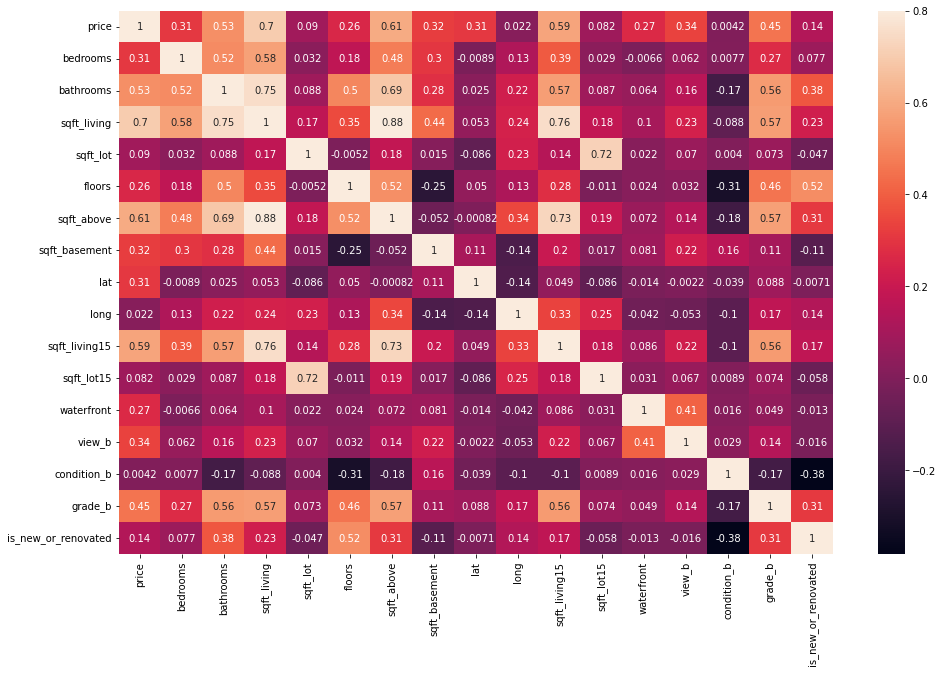

condition_b            0.0042
long                   0.0216
sqft_lot15             0.0824
sqft_lot               0.0897
is_new_or_renovated    0.1375
floors                 0.2568
waterfront             0.2664
lat                    0.3070
bedrooms               0.3083
sqft_basement          0.3238
view_b                 0.3379
grade_b                0.4546
bathrooms              0.5251
sqft_living15          0.5854
sqft_above             0.6056
sqft_living            0.7020
price                  1.0000
Name: price, dtype: float64

In [ ]:
corrmat = hdf.corr()
fig = plt.figure(figsize = (16,10))

sns.heatmap(corrmat,vmax=0.8, annot=True)
plt.show()

corrT = hdf.corr(method = 'pearson').round(4)
corrT = corrT.sort_values(by=['price'])
corrT['price']

# print(hdf)